In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import numpy as np

from tqdm.notebook import trange, tqdm

from pathlib import Path
colour = Path('../GTA_images/Simple/Colour')
depth = Path('../GTA_images/Simple/Depth')

import sys
sys.path.append('../')

from depth_Functions import (
    import_raw_colour_image, 
    import_raw_depth_image, 
    show_img,
    show_array_of_images
)

from Feature_Extraction import (
    create_local_feature_vector,
    process_patches
)

# [Equation](https://www.cs.cornell.edu/~asaxena/learningdepth/ijcv_monocular3dreconstruction.pdf)

Our goal is to create parameters for the function:

$$d_i = \theta_r x_i$$

To optimise the following equation:

$$P(d|X;\theta;\sigma_{1r}) = \frac{1}{Z}\exp{\left({-\sum_\limits{i=1}^{M}d_i-x_i^T\theta_r}\right)}$$

## Variables

| Variables |Description|
|-|-|
|$P(d|X)$|probable depth d given image features X|
|$\theta$|parameter calculated during training|
| Z | Normalisation constant |
| M | Number of patches |
|$d_i$|depth at a given patch|
|$x_i$|feature vector at patch|


# Training

## Equations

In training our goal is to determine $\theta$, this is done by maximising the value l(d):

 $$l(d) = \log{P(d|X;\theta_r)}$$


 $$l(d) = \log\left(\frac{1}{Z}\right)\left({-\sum_\limits{i=1}^{M}d_i-\theta_r x_i^T}\right)$$

Linear least squares is used to determine the value of $\theta$ that will maximise l(d), which occurs as:

$$\left({\sum_\limits{i=1}^{M}d_i-x_i^T\theta_r}\right) \rightarrow 0$$

$\therefore$ we can find the least square of the equation:

$$d_i = \theta_rx_i^T$$

In [ ]:
from scipy import optimize

def function(x, *𝜃):
    return x @ np.array(𝜃)

def least_squares(features, depth, 𝜃):
    return optimize.curve_fit(function, 
                              xdata=features.reshape(-1, features.shape[-1]), 
                              ydata=depth.flatten(),
                              p0=𝜃)

# Example

## Training Image

In [ ]:
sorted(colour.iterdir())

In [ ]:
colour_images = [import_raw_colour_image(str(file)) for file in sorted(colour.iterdir())]
depth_images = [import_raw_depth_image(str(file)) for file in sorted(depth.iterdir())]

In [ ]:
show_array_of_images([x for y in zip(colour_images, depth_images) for x in y], 
                     shape=(6,2), depthmap=True)

## Get the feature values of each patch

In [ ]:
from tqdm.notebook import tqdm

features_6x6 = [process_patches(image, (6,6), function=create_local_feature_vector)
                for image in tqdm(colour_images, total=6, leave=False)]

## Set an estimate for $\theta$: 
required as otherwise scipy will assume it is a scalar

In [ ]:
𝜃 = [1e-5 for i in range(features_6x6[0].shape[-1])]

## Train accross each of first five images

In [ ]:
for feature, depth in tqdm(zip(features_6x6[:-1], depth_images[:-1]),
                           total=len(features_6x6[:-1]), leave=False):
    𝜃,_ = least_squares(feature,  depth, 𝜃)

In [ ]:
𝜃

In [ ]:
import math

mean, std = np.mean(𝜃), np.std(𝜃)

𝜃_stand = [(weight-mean)/std for weight in 𝜃] 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
_, axis = plt.subplots(1,1,figsize=(16,8))

features = [f"LY{i}" for i in range(9)] + ["LCr1", "LCb1"] + [f"E{i}" for i in range(0,180,30)]

total = features + [f"{f}^2" for f in features]

axis.scatter(total, 𝜃_stand)

for x,y in enumerate(𝜃_stand):
    axis.annotate(total[x], xy=(x,y))

## Predict the depth for the final image

In [ ]:
predicted_depth = features_6x6[-1] @ 𝜃

In [ ]:
show_img(predicted_depth, depthmap=True)
show_img(depth_images[-1], depthmap=True)

# Experiment at different patch sizes

In [ ]:
weights = [[1e-5 for i in range(features_6x6[0].shape[-1])] for i in range(4)]

show_img(depth_images[-1])

for i in trange(4):
    features_train = [process_patches(image, ((i+1)*6,(i+1)*6), function=create_local_feature_vector)
                for image in tqdm(colour_images[:-1], total=5, leave=False, desc='feature extraction')]
    
    for feature, depth in tqdm(zip(features_train, depth_images[:-1]),
                           total=len(features_train), leave=False, desc='training'):
        weights[i],_ = least_squares(feature,  depth, weights[i])

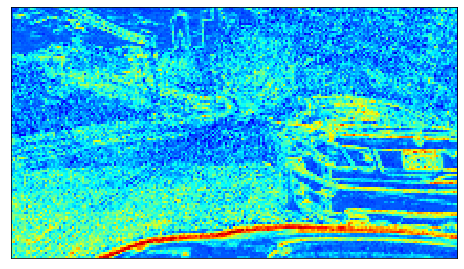

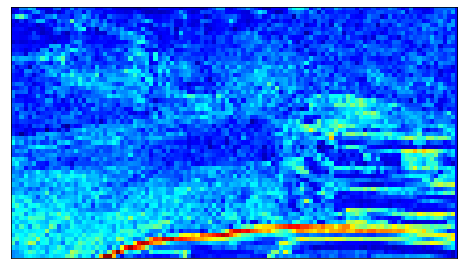

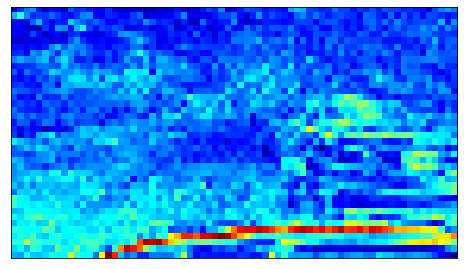

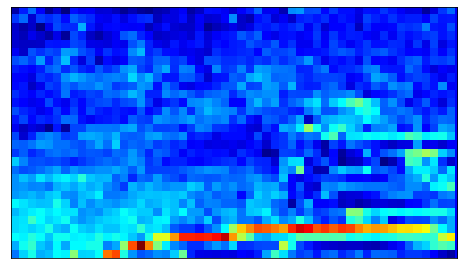

In [33]:
for i, weight in enumerate(weights):
    features_test = process_patches(colour_images[-1], ((i+1)*6,(i+1)*6), function=create_local_feature_vector, name=f'{((i+1)*6}x{(i+1)*6)}')
    show_img(features_test @ weight, depthmap=True)

# Experiment with a $\theta$ for each row

It can be considered that information within a row will be similar whilst information between rows will be different i.e. blue at the top most likely indicates sky, blue at the base mostly indicates sea

In [34]:
𝜃 = [[1e-5 for i in range(features_6x6[0].shape[-1])] for i in range(features_6x6[0].shape[0])]

In [36]:
len(𝜃[0])

34

In [42]:
features_6x6[0][0].shape

(1280, 34)

In [53]:
for feature, depth in tqdm(zip(features_6x6[:-1], depth_images[:-1]),
                           total=len(features_6x6[:-1]), leave=False):
    for i in trange(feature.shape[0], leave=False):
        𝜃[i],_ = least_squares(feature[i],  depth[i], 𝜃[i])

In [58]:
predicted_depth = np.zeros(features_6x6[-1].shape[:-1])

for row_number, feature_row  in enumerate(features_6x6[-1]):
    predicted_depth[row_number] = feature_row @  𝜃[row_number]

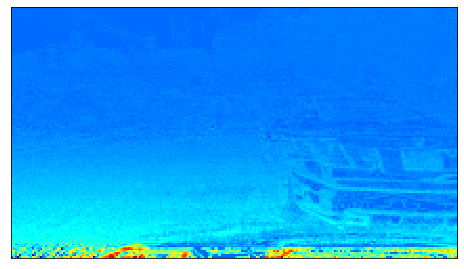

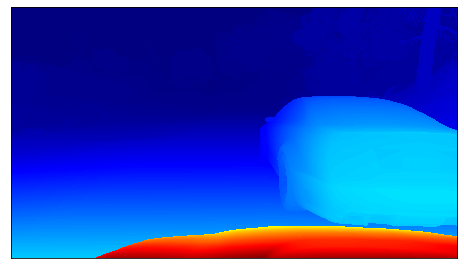

In [60]:
show_img(predicted_depth, depthmap=True)
show_img(depth_images[-1], depthmap=True)